In [17]:
from __future__ import print_function
from __future__ import division
from keras.utils import plot_model
from keras.models import Sequential, model_from_json
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from lib.pretty_testing import predict_test, class_weights_max, confusion_matrix
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
top_words = 5000
embedding_vector_length = 32
maxlen = 100
epochs = 25
#classes = ['poteri', 'scadenza', 'assemblea', 'clausola', 'non_riconducibile']
classes = ['poteri', 'assemblea', 'clausola', 'non_riconducibile']

In [3]:
# load prepared data
with open('../extraction/dataset.p') as f:
    data, labels = pickle.load(f)

In [4]:
padded_data = sequence.pad_sequences(data, maxlen, padding="pre", truncating="post", value=0, dtype='uint32')
labels = np.array(labels)

In [5]:
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=maxlen, mask_zero=True))
model.add(LSTM(32, dropout=0.2)) #return_sequences=True
model.add(Dense(len(classes), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 168,452
Trainable params: 168,452
Non-trainable params: 0
_________________________________________________________________


In [6]:
#plot_model(model, to_file='model.png')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, train_size=0.8, stratify=labels)
y_train_cat = to_categorical(y_train, num_classes=len(classes))
y_test_cat = to_categorical(y_test, num_classes=len(classes))

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
[l.get_weights()[0].shape for l in model.layers]

[(5000, 32), (32, 128), (32, 4)]

In [9]:
class_weights = class_weights_max(labels)

In [10]:
class_weights

{0: 6.5042589437819425, 1: 6.616984402079723, 2: 6.537671232876712, 3: 1.0}

In [11]:
h = model.fit(X_train,  y_train_cat, epochs=epochs, batch_size=32, verbose=0, class_weight=class_weights)
#h.history

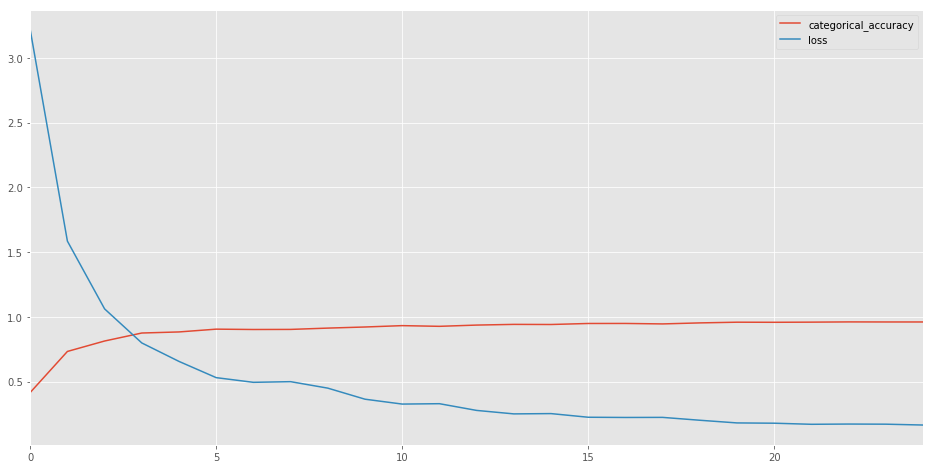

In [12]:
df = pd.DataFrame(h.history)
p = df.plot(figsize=(16,8))

In [13]:
y_pred = predict_test(model, X_test, y_test, classes)

()
Test classification report
Accuracy: 0.842011
             precision    recall  f1-score   support

          0       0.65      0.77      0.71       118
          1       0.74      0.88      0.80       115
          2       0.73      0.80      0.76       117
          3       0.92      0.85      0.89       764

avg / total       0.85      0.84      0.85      1114

Test confusion Matrix
                                 poteri         assemblea          clausola non_riconducibile
               poteri              91.0               1.0               0.0              26.0
            assemblea               3.0             101.0               0.0              11.0
             clausola               1.0               3.0              94.0              19.0
    non_riconducibile              45.0              32.0              35.0             652.0


In [16]:
precision_recall_fscore_support(y_test, y_pred)

(array([ 0.65      ,  0.73722628,  0.72868217,  0.92090395]),
 array([ 0.77118644,  0.87826087,  0.8034188 ,  0.85340314]),
 array([ 0.70542636,  0.8015873 ,  0.76422764,  0.88586957]),
 array([118, 115, 117, 764]))

In [18]:
confusion_matrix(y_test, y_pred)

array([[ 91,   1,   0,  26],
       [  3, 101,   0,  11],
       [  1,   3,  94,  19],
       [ 45,  32,  35, 652]])

In [19]:
with open('models/extraction_model_30.json','w') as f:
    f.write(model.to_json())

In [20]:
model.save_weights("models/extraction_weights_30.h5")